# MNIST Adversarial Images with TensorFlow

Create adversarial images to fool a MNIST classifier in TensorFlow

TODO: a little background on the tech challenge

## Approach

1. The basic need-to-know about adversarial images
2. Get data to be used throughout notebook
3. Build a simple CNN (test model)
4. Train it on MNIST 
5. Show model classification of 10 handwritten 2s
6. Create adversarial image to classify 2s as 6s
7. Test adversarial image with original model (in step 2)
8. Conclusion

## The (very high level) Basics

TODO: finish

## Data

In [158]:
# Dependencies for entire notebook here
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# Take a look the training data
print('Training.images shape: ', mnist.train.images.shape)
print('Training.labels shape: ', mnist.train.labels.shape)
print('Shape of an image: ', mnist.train.images[0].shape)
print('Example label: ', mnist.train.labels[0])

Training.images shape:  (55000, 784)
Training.labels shape:  (55000, 10)
Shape of an image:  (784,)
Example label:  [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


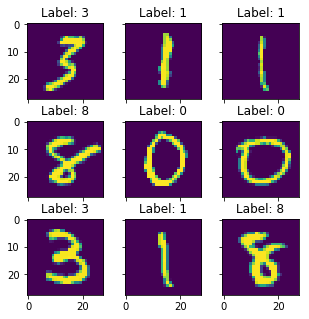

In [393]:
# Review a few images
image_list = mnist.train.images[0:9]
image_list_labels = mnist.train.labels[0:9]

# https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html#imagegrid
fig = plt.figure(1, (5., 5.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for i in range(len(image_list)):
    image = image_list[i].reshape(28,28)
    grid[i].imshow(image)
    grid[i].set_title('Label: {0}'.format(image_list_labels[i].argmax()))

plt.show()

## Benchmark CNN (for testing)

Based on challenge requirements, building model using tensorflow low-level API

In [5]:
# To run nicely in jupyter notebook
sess = tf.InteractiveSession()

In [6]:
# Functions for creating weights and biases
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Functions for convolution and pooling functions
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pooling_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [7]:
# Create placeholders nodes for images and label inputs
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [58]:
# Probabilities - output from model (not the same as logits)
y = tf.nn.softmax(y_conv)

Benchmark model to be used for testing classification on real images with and without noise

In [8]:
# y = (Wx +b)
# Input layer
x_image = tf.reshape(x, [-1,28,28,1]) # mnist image comes in as 784 vector

# Conv layer 1 - 32x5x5
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
x_pool1 = max_pooling_2x2(x_conv1)

# Conv layer 2 - 64x5x5
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
x_conv2 = tf.nn.relu(conv2d(x_pool1, W_conv2) + b_conv2)
x_pool2 = max_pooling_2x2(x_conv2)

# Flatten - keras 'flatten'
x_flat = tf.reshape(x_pool2, [-1, 7*7*64])

# Dense fully connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024]) # max pooling reduced image to 7x7
b_fc1 = bias_variable([1024])
x_fc1 = tf.nn.relu(tf.matmul(x_flat, W_fc1) + b_fc1)

# Regularization with dropout
keep_prob = tf.placeholder(tf.float32)
x_fc1_drop = tf.nn.dropout(x_fc1, keep_prob)

# Classification layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(x_fc1_drop, W_fc2) + b_fc2

In [9]:
# Loss and optimizer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-2).minimize(cross_entropy)

In [13]:
# Setup to test accuracy of model
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [236]:
# Initilize all global variables
sess.run(tf.global_variables_initializer())

In [241]:
# Train model
for i in range(2000):
    batch = mnist.train.next_batch(50)
    if i%500 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))

    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.4})

step 0, training accuracy 0.62
step 100, training accuracy 0.86
step 200, training accuracy 0.88
step 300, training accuracy 0.92
step 400, training accuracy 0.76
step 500, training accuracy 0.94
step 600, training accuracy 0.94
step 700, training accuracy 0.9
step 800, training accuracy 0.9
step 900, training accuracy 0.94


In [394]:
# Run trained model against test data
print("test accuracy %g"%accuracy.eval(feed_dict={x: mnist.test.images[0:2000], 
                                                  y_: mnist.test.labels[0:2000], keep_prob: 1.0}))

test accuracy 0.9455


In [292]:
# Get 10 2s [:,2] from top 500 [0:500], nonzero returns tuple, get index[0], then first 10 [0:10]
index_of_2s = np.nonzero(mnist.test.labels[0:500][:,2])[0][0:10]
x_batch = mnist.test.images[index_of_2s]

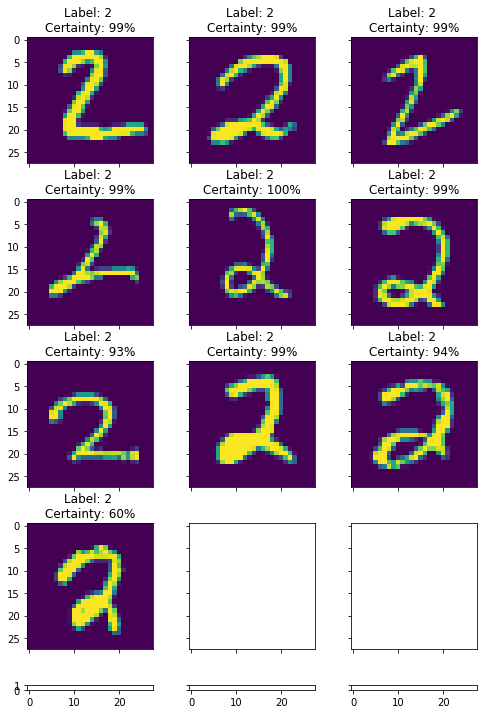

In [392]:
plot_predictions(x_batch)

In [391]:
def plot_predictions(image_list):
    prob = y.eval(feed_dict={x: image_list, keep_prob: 1.0})
    
    pred_list = np.zeros(len(image_list)).astype(int)
    pct_list = np.zeros(len(image_list)).astype(int)
    
    for i in range(len(prob)):
        pred_list[i] = np.argmax(prob[i]) # for mnist index == classification
        pct_list[i] = prob[i][pred_list[i]] * 100

    # Setup image grid
    fig = plt.figure(1, (12., 12.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(5, 3),  # creates grid of axes
                     axes_pad=0.5,  # pad between axes in inch.
                     )

    # Populate image grid
    for i in range(len(image_list)):
        image = image_list[i].reshape(28,28)
        grid[i].imshow(image)
        grid[i].set_title('Label: {0} \nCertainty: {1}%' \
                          .format(pred_list[i], 
                                  pct_list[i]))
        
    plt.show()

In [395]:
sess.close()

Review correctly classified images

## Adversarial Images

In [ ]:
# expand on benchmark model using low-level API